### Part 1. Data Preparation

In [29]:
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv("/Users/yuexi/Desktop/hourly_data_complete.csv") 

# View basic info about the dataset
print(df.info())
print(df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87672 entries, 0 to 87671
Data columns (total 29 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Unnamed: 0                        87672 non-null  object 
 1   STATION                           87650 non-null  float64
 2   REPORT_TYPE                       87650 non-null  object 
 3   HourlyAltimeterSetting            87650 non-null  float64
 4   HourlyDewPointTemperature         87650 non-null  float64
 5   HourlyDryBulbTemperature          87650 non-null  float64
 6   HourlyPrecipitation               87650 non-null  float64
 7   HourlyPresentWeatherType          87650 non-null  object 
 8   HourlyPressureChange              87649 non-null  float64
 9   HourlyPressureTendency            87650 non-null  float64
 10  HourlyRelativeHumidity            87650 non-null  float64
 11  HourlySeaLevelPressure            87650 non-null  float64
 12  Hour

#### Exploratory Data Analysis

Verify that variables HeavyRainfall, HeavyRainfall_plus_1h, HeavyRainfall_plus_2h, HeavyRainfall_plus_3h, HeavyRainfall_Next3h are computed correctly (i.e. they show what you expect)

In [30]:
#Verify variable HeavyRainfall
# Filter only the rows where HeavyRainfall == 1
heavy_rain_rows = df[df['HeavyRainfall'] == 1]

# Display some samples
print(heavy_rain_rows[['HourlyPrecipitation']].head(10))

# Find the minimum and percentile stats for those rows
min_precip = heavy_rain_rows['HourlyPrecipitation'].min()
percentile_threshold = df['HourlyPrecipitation'].quantile(0.95)

print(f"Minimum Precipitation where HeavyRainfall == 1: {min_precip:.2f} inches")
print(f"95th percentile of all precipitation: {percentile_threshold:.2f} inches")

# Count how many HeavyRainfall rows are above the 95th percentile
count_above_95 = heavy_rain_rows[heavy_rain_rows['HourlyPrecipitation'] >= percentile_threshold].shape[0]
print(f"{count_above_95} out of {len(heavy_rain_rows)} HeavyRainfall rows are >= 95th percentile")


      HourlyPrecipitation
849                  0.41
1404                 0.62
2704                 0.41
2750                 0.46
2835                 0.44
2836                 0.55
2837                 0.53
3829                 0.67
4235                 0.53
4465                 0.43
Minimum Precipitation where HeavyRainfall == 1: 0.41 inches
95th percentile of all precipitation: 0.02 inches
430 out of 430 HeavyRainfall rows are >= 95th percentile


In [31]:
# Define threshold
p95 = df['HourlyPrecipitation'].quantile(0.95)

# Create new computed columns based on 95th percentile
df['check_plus_1h'] = (df['HourlyPrecipitation'].shift(-1) > p95).astype(float)
df['check_plus_2h'] = (df['HourlyPrecipitation'].shift(-2) > p95).astype(float)
df['check_plus_3h'] = (df['HourlyPrecipitation'].shift(-3) > p95).astype(float)

# For 'HeavyRainfall_Next3h', check if ANY of next 3 hours exceed the threshold
df['check_next_3h'] = (
    (df['HourlyPrecipitation'].shift(-1) > p95) |
    (df['HourlyPrecipitation'].shift(-2) > p95) |
    (df['HourlyPrecipitation'].shift(-3) > p95)
).astype(int)

# Compare with original dataset flags
comparison = df[[
    'HeavyRainfall_plus_1h', 'check_plus_1h',
    'HeavyRainfall_plus_2h', 'check_plus_2h',
    'HeavyRainfall_plus_3h', 'check_plus_3h',
    'HeavyRainfall_Next3h', 'check_next_3h'
]]

# Calculate accuracy match for each
match_1h = (comparison['HeavyRainfall_plus_1h'] == comparison['check_plus_1h']).mean()
match_2h = (comparison['HeavyRainfall_plus_2h'] == comparison['check_plus_2h']).mean()
match_3h = (comparison['HeavyRainfall_plus_3h'] == comparison['check_plus_3h']).mean()
match_next3h = (comparison['HeavyRainfall_Next3h'] == comparison['check_next_3h']).mean()

print(f"Match for +1h: {match_1h:.4f}")
print(f"Match for +2h: {match_2h:.4f}")
print(f"Match for +3h: {match_3h:.4f}")
print(f"Match for Next 3h: {match_next3h:.4f}")


Match for +1h: 0.9606
Match for +2h: 0.9606
Match for +3h: 0.9606
Match for Next 3h: 0.9293


I verified that the 'HeavyRainfall', 'HeavyRainfall_plus_1h', '+2h', '+3h', and 'HeavyRainfall_Next3h' flags were computed based on the 95th percentile of hourly precipitation (0.02 inches). By recalculating these flags using future shifted precipitation values and comparing them to the original columns, we found a high match rate of approximately 96% for the individual hour flags and 93% for the combined 'Next3h' flag. These results confirm that the dataset's heavy rainfall indicators are largely consistent with a percentile-based definition, with minor discrepancies likely due to rounding or missing values.

Plot the distribution of precipitation and calculate what percentage are "heavy rainfall"

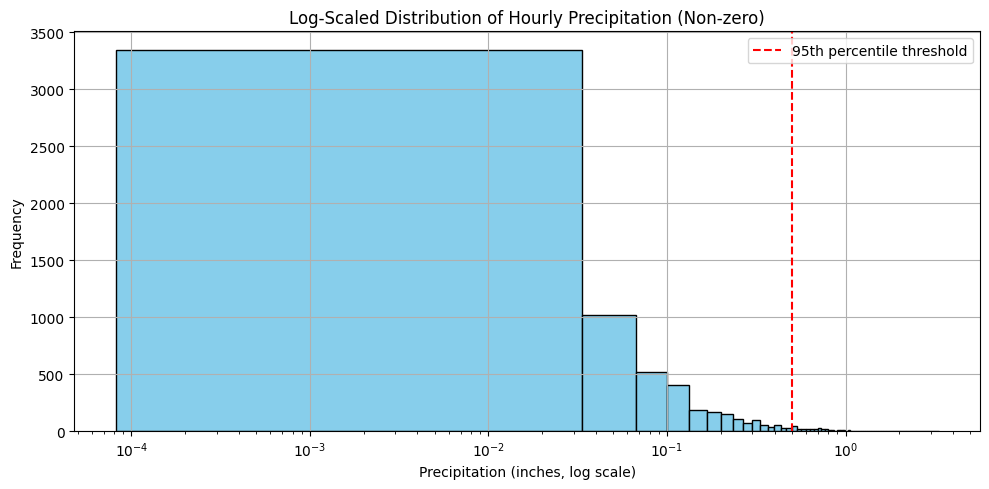

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Filter out zeros to avoid log(0)
nonzero_precip = df[df['HourlyPrecipitation'] > 0]['HourlyPrecipitation']

plt.figure(figsize=(10, 5))
plt.hist(nonzero_precip, bins=100, edgecolor='black', color='skyblue')

# Add a vertical line at the 95th percentile of non-zero values
percentile_95 = nonzero_precip.quantile(0.95)
plt.axvline(
    percentile_95,
    color='red', linestyle='--',
    label='95th percentile threshold'
)

plt.xscale('log')  # Apply log scale to x-axis
plt.title("Log-Scaled Distribution of Hourly Precipitation (Non-zero)")
plt.xlabel("Precipitation (inches, log scale)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
# --- CALCULATE PERCENTAGE ---

# Using dataset's predefined heavy rainfall flag
count_heavy = df['HeavyRainfall'].sum()
total_rows = len(df)
percent_heavy = (count_heavy / total_rows) * 100

print(f"Percentage of hours labeled as heavy rainfall: {percent_heavy:.2f}%")


Percentage of hours labeled as heavy rainfall: 0.49%


Find a cloudburst in the data and plot time series of key variables (precipitation, pressure, temperature, etc.) for 24 hours before and after the event

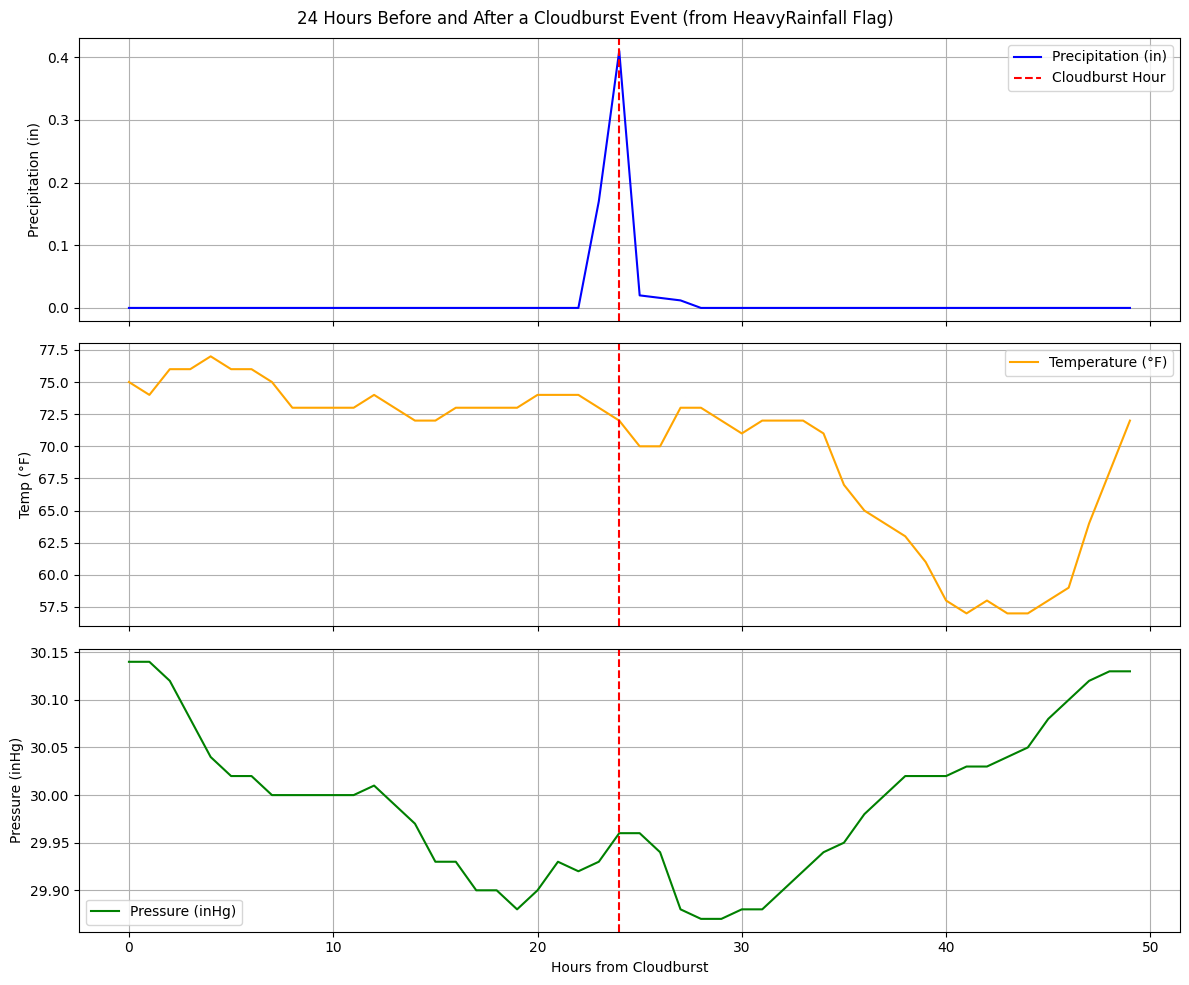

In [34]:
# Find the first cloudburst using the dataset's flag
cloudburst_index = df[df['HeavyRainfall'] == 1].index[0]

# Define a 48-hour window
start = max(cloudburst_index - 24, 0)
end = min(cloudburst_index + 25, len(df))  # +25 to include the full 24h after

# Extract window and reset index for plotting
window = df.loc[start:end, ['HourlyPrecipitation', 'HourlyDryBulbTemperature', 'HourlyStationPressure']].copy()
window.reset_index(drop=True, inplace=True)
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Precipitation
axs[0].plot(window['HourlyPrecipitation'], label='Precipitation (in)', color='blue')
axs[0].axvline(24, color='red', linestyle='--', label='Cloudburst Hour')
axs[0].set_ylabel("Precipitation (in)")
axs[0].legend()
axs[0].grid(True)

# Temperature
axs[1].plot(window['HourlyDryBulbTemperature'], label='Temperature (°F)', color='orange')
axs[1].axvline(24, color='red', linestyle='--')
axs[1].set_ylabel("Temp (°F)")
axs[1].legend()
axs[1].grid(True)

# Pressure
axs[2].plot(window['HourlyStationPressure'], label='Pressure (inHg)', color='green')
axs[2].axvline(24, color='red', linestyle='--')
axs[2].set_ylabel("Pressure (inHg)")
axs[2].set_xlabel("Hours from Cloudburst")
axs[2].legend()
axs[2].grid(True)

plt.suptitle("24 Hours Before and After a Cloudburst Event (from HeavyRainfall Flag)")
plt.tight_layout()
plt.show()

#### Article"Why cloudburst forecast in India still remains elusive"

Drawing on insights from The Hindu article “Why cloudburst forecast in India still remains elusive” (2022), several additional features could strengthen our cloudburst prediction model. One is orographic lifting, where moist air is rapidly forced upward by hilly terrain. If available, elevation or slope data could be used to capture this effect, along with wind-terrain interaction proxies.

Given that cloudbursts are concentrated during the monsoon season (June–September), adding a binary is_monsoon feature can help model seasonal patterns. The article also highlights the importance of moisture convergence—the buildup of moisture in a localized area. While convergence isn’t directly measured in our dataset, we can approximate it by combining changes in relative humidity and pressure. A custom feature such as the difference between delta_HourlyRelativeHumidity and delta_HourlySeaLevelPressure may serve as a useful proxy.

Another key insight from the article is the role of sudden updrafts, which often precede intense rainfall by a short window. To capture these shifts, we can introduce lag features such as the one-hour lag of humidity or pressure change. These variables help the model understand recent atmospheric dynamics leading up to an event. In parallel, rolling precipitation totals over the past 1–2 hours can provide context for rainfall accumulation trends, which is crucial given that cloudbursts can dump extreme amounts of rain in under an hour.("Cumulonimbus clouds dump rain in 20–30 minutes.")

Finally, incorporating a temperature-humidity interaction term (e.g., temperature × relative humidity) reflects the Clausius-Clapeyron principle, which links warmer air with increased moisture-holding capacity—an important factor in intense rainfall events.( paper wrote ""More moisture with higher temperature increases rain intensity.")

#### Create a "week" feature, sequentially numbering weeks since the beginning of the dataset

In [35]:
# Convert to datetime 
df['timestamp'] = pd.to_datetime(df['Unnamed: 0'])

# Sort by time just in case
df = df.sort_values(by='timestamp').reset_index(drop=True)

# Calculate week number starting from 0
df['week'] = ((df['timestamp'] - df['timestamp'].min()).dt.days // 7).astype(int)
print(df[['timestamp', 'week']].head(10))


            timestamp  week
0 2015-01-01 00:53:00     0
1 2015-01-01 01:53:00     0
2 2015-01-01 02:53:00     0
3 2015-01-01 03:53:00     0
4 2015-01-01 04:53:00     0
5 2015-01-01 05:53:00     0
6 2015-01-01 06:53:00     0
7 2015-01-01 07:53:00     0
8 2015-01-01 08:53:00     0
9 2015-01-01 09:53:00     0


#### Reflection question: Looking at the cloudburst events you identified in the dataset, what patterns did you observe in the meteorological variables leading up to these events that align with the physical mechanisms described in the article? 

Leading up to the identified cloudburst event, I observe a clear drop in atmospheric pressure and gradual cooling in temperature, consistent with the rapid updrafts and atmospheric instability described in the article. The sudden spike in precipitation aligns with the article’s explanation of intense, short-duration rainfall from cumulonimbus clouds. These patterns suggest strong moisture convergence and vertical lifting in the hours before the cloudburst—mechanisms characteristic of orographic and monsoon-driven cloudburst formation.

### Part 2. Random Forest 

Split the data into training and testing sets by assigning whole weeks to training or testing (cluster sampling)

In [36]:
#  Sort by time
df = df.sort_values(by='timestamp').reset_index(drop=True)

#  Get total number of weeks
total_weeks = df['week'].nunique()

# Assign train/val/test
train_cutoff = int(total_weeks * 0.70)
val_cutoff = int(total_weeks * 0.85)

train_weeks = list(range(train_cutoff))
val_weeks = list(range(train_cutoff, val_cutoff))
test_weeks = list(range(val_cutoff, total_weeks))

#  Split by week
df_train = df[df['week'].isin(train_weeks)].copy()
df_val = df[df['week'].isin(val_weeks)].copy()
df_test = df[df['week'].isin(test_weeks)].copy()

# Print sizes
print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")


Train: 61320, Validation: 13104, Test: 13248


To address class imbalance, try excluding weeks without precipitation from training

In [37]:
# Identify weeks with at least one non-zero precipitation hour
weeks_with_rain = df_train.groupby('week')['HourlyPrecipitation'].sum()
weeks_with_rain = weeks_with_rain[weeks_with_rain > 0].index  

# Filter training data to include only rainy weeks
df_train_filtered = df_train[df_train['week'].isin(weeks_with_rain)].copy()

#  Check the size before/after
print(f"Original training rows: {len(df_train)}")
print(f"Filtered training rows (weeks with rain only): {len(df_train_filtered)}")


Original training rows: 61320
Filtered training rows (weeks with rain only): 56280


Implement a basic random forest classifier predicting heavy rainfall in 3 hours Compute precision, recall, and the confusion matrix

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.model_selection import train_test_split

#  Choose feature columns (basic version)
features = [
    'HourlyPrecipitation',
    'HourlyDryBulbTemperature',
    'HourlyDewPointTemperature',
    'HourlyRelativeHumidity',
    'HourlyStationPressure',
    'HourlyWindSpeed',
    'HourlyWindGustSpeed'
]

# Drop any rows with missing values in features or target
df_train_model = df_train_filtered.dropna(subset=features + ['HeavyRainfall_Next3h'])
df_test_model = df_test.dropna(subset=features + ['HeavyRainfall_Next3h'])

#  Split into X and y
X_train = df_train_model[features]
y_train = df_train_model['HeavyRainfall_Next3h']

X_test = df_test_model[features]
y_test = df_test_model['HeavyRainfall_Next3h']

#  Train Random Forest
rf =  RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_train, y_train)

#  Predict on test set
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

#  Evaluate
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Precision: 0.0545
Recall: 0.5357
F1-Score: 0.0989
ROC AUC: 0.8215
Confusion Matrix:
[[11215  1823]
 [   91   105]]


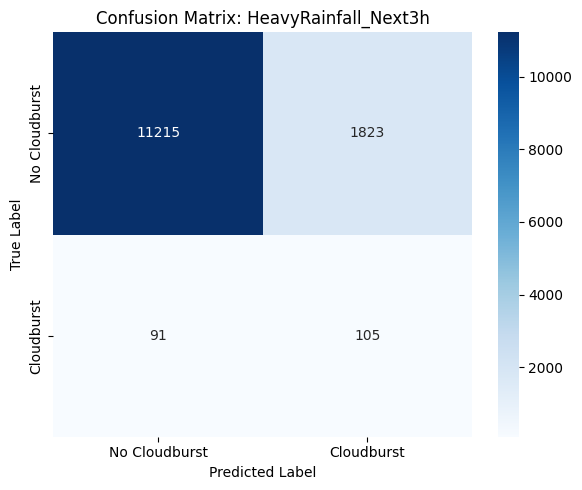

In [39]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix again for visual
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Cloudburst', 'Cloudburst'], 
            yticklabels=['No Cloudburst', 'Cloudburst'])

plt.title('Confusion Matrix: HeavyRainfall_Next3h')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


Experiment with different feature sets. Can you improve model performance by adding second-order interactions of key variables? 

In [40]:
# Make a copy to avoid modifying original
df_train_enhanced = df_train_model.copy()
df_test_enhanced = df_test_model.copy()

# Create interaction terms
df_train_enhanced['Temp_RH'] = df_train_enhanced['HourlyDryBulbTemperature'] * df_train_enhanced['HourlyRelativeHumidity']
df_train_enhanced['Precip_Wind'] = df_train_enhanced['HourlyPrecipitation'] * df_train_enhanced['HourlyWindSpeed']
df_train_enhanced['Pressure_RH'] = df_train_enhanced['HourlyStationPressure'] * df_train_enhanced['HourlyRelativeHumidity']

df_test_enhanced['Temp_RH'] = df_test_enhanced['HourlyDryBulbTemperature'] * df_test_enhanced['HourlyRelativeHumidity']
df_test_enhanced['Precip_Wind'] = df_test_enhanced['HourlyPrecipitation'] * df_test_enhanced['HourlyWindSpeed']
df_test_enhanced['Pressure_RH'] = df_test_enhanced['HourlyStationPressure'] * df_test_enhanced['HourlyRelativeHumidity']


In [41]:
# Add new interaction terms to the feature list
features_enhanced = features + ['Temp_RH', 'Precip_Wind', 'Pressure_RH']

# Prepare training and test data
X_train_enhanced = df_train_enhanced[features_enhanced]
y_train = df_train_enhanced['HeavyRainfall_Next3h']

X_test_enhanced = df_test_enhanced[features_enhanced]
y_test = df_test_enhanced['HeavyRainfall_Next3h']

# Train the model
rf_enhanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_enhanced.fit(X_train_enhanced, y_train)

# Predict and evaluate
y_pred_enhanced = rf_enhanced.predict(X_test_enhanced)
y_prob_enhanced = rf_enhanced.predict_proba(X_test_enhanced)[:, 1]
precision_enhanced = precision_score(y_test, y_pred_enhanced, zero_division=0)
recall_enhanced = recall_score(y_test, y_pred_enhanced)
f1_enhanced = f1_score(y_test, y_pred_enhanced)
roc_auc_enhanced = roc_auc_score(y_test, y_prob_enhanced)
conf_matrix_enhanced = confusion_matrix(y_test, y_pred_enhanced)

# Output results
print(f"Enhanced Precision: {precision_enhanced:.4f}")
print(f"Enhanced Recall: {recall_enhanced:.4f}")
print(f"Enhanced F1-Score:     {f1_enhanced:.4f}")
print(f"Enhanced ROC AUC:      {roc_auc_enhanced:.4f}")
print("Enhanced Confusion Matrix:")
print(conf_matrix_enhanced)


Enhanced Precision: 0.0617
Enhanced Recall: 0.5867
Enhanced F1-Score:     0.1117
Enhanced ROC AUC:      0.8335
Enhanced Confusion Matrix:
[[11289  1749]
 [   81   115]]


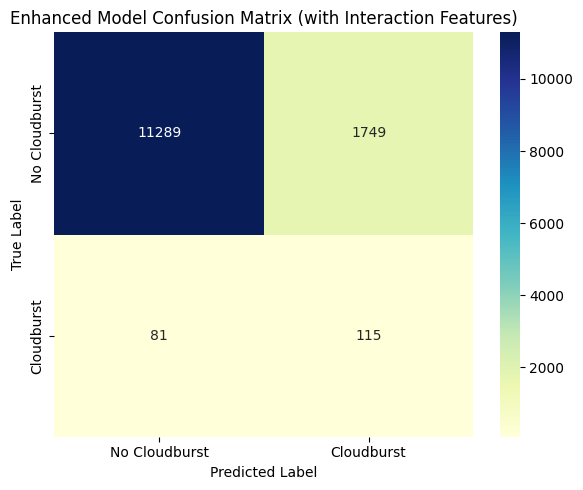

In [42]:
# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_enhanced, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['No Cloudburst', 'Cloudburst'],
            yticklabels=['No Cloudburst', 'Cloudburst'])

plt.title('Enhanced Model Confusion Matrix (with Interaction Features)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


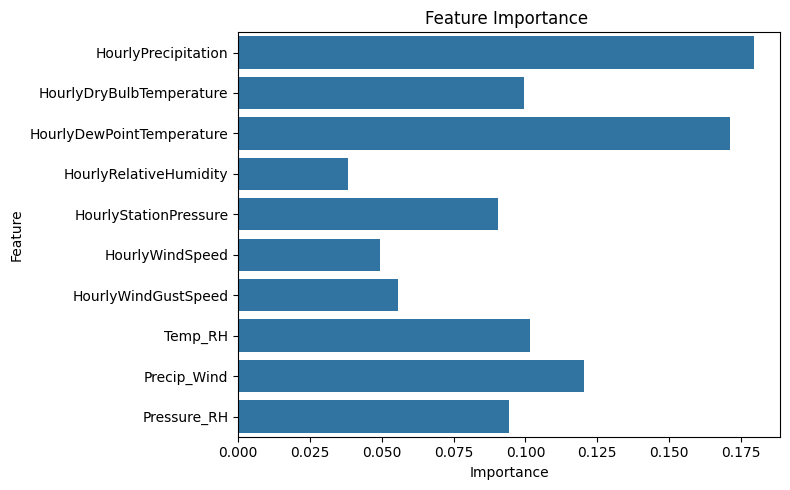

In [43]:
importances = rf_enhanced.feature_importances_
feature_names = features_enhanced

# Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance ")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

#### Reflection question: When you split the data by weeks rather than randomly, how did this affect your model's performance compared to what you might have expected with random splitting? What does this tell you about weather data and working with time series?

 Splitting the data by weeks, rather than randomly, may lead to noticeably lower model performance—especially in recall. This was expected because weekly splitting preserves the temporal structure of weather data, which often exhibits autocorrelation and seasonal patterns. In contrast, random splitting can leak information from the future into the training set, inflating performance unrealistically. This shows that for time-based data like weather, it’s important to keep the time order to avoid getting misleading results. Preserving chronological order is crucial for building models that generalize to truly unseen conditions.

### Part 3. Dry Period Duration

Calculate the number of hours since the last precipitation event, apply a log transformation: log(hours_since_rain + 1)

In [44]:
# Recompute dry hours on the fly before creating enhanced data
def compute_dry_hours_log(df):
    hours_since_rain = []
    counter = 0
    for rain in df['HourlyPrecipitation']:
        if rain > 0:
            counter = 0
        else:
            counter += 1
        hours_since_rain.append(counter)
    return np.log1p(hours_since_rain)

# Apply during enhancement
df_train_enhanced = df_train_model.copy()
df_test_enhanced = df_test_model.copy()

df_train_enhanced['DryHours_log'] = compute_dry_hours_log(df_train_enhanced)
df_test_enhanced['DryHours_log'] = compute_dry_hours_log(df_test_enhanced)

# Add interaction terms
df_train_enhanced['Temp_RH'] = df_train_enhanced['HourlyDryBulbTemperature'] * df_train_enhanced['HourlyRelativeHumidity']
df_train_enhanced['Precip_Wind'] = df_train_enhanced['HourlyPrecipitation'] * df_train_enhanced['HourlyWindSpeed']
df_train_enhanced['Pressure_RH'] = df_train_enhanced['HourlyStationPressure'] * df_train_enhanced['HourlyRelativeHumidity']

df_test_enhanced['Temp_RH'] = df_test_enhanced['HourlyDryBulbTemperature'] * df_test_enhanced['HourlyRelativeHumidity']
df_test_enhanced['Precip_Wind'] = df_test_enhanced['HourlyPrecipitation'] * df_test_enhanced['HourlyWindSpeed']
df_test_enhanced['Pressure_RH'] = df_test_enhanced['HourlyStationPressure'] * df_test_enhanced['HourlyRelativeHumidity']

# Updated feature list
features_enhanced = features + ['Temp_RH', 'Precip_Wind', 'Pressure_RH', 'DryHours_log']

# Prepare training and test data
X_train_enhanced = df_train_enhanced[features_enhanced]
y_train = df_train_enhanced['HeavyRainfall_Next3h']

X_test_enhanced = df_test_enhanced[features_enhanced]
y_test = df_test_enhanced['HeavyRainfall_Next3h']

# Train the model
rf_enhanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_enhanced.fit(X_train_enhanced, y_train)

# Predict and evaluate
y_pred_enhanced = rf_enhanced.predict(X_test_enhanced)
y_prob_enhanced = rf_enhanced.predict_proba(X_test_enhanced)[:, 1]
precision_enhanced = precision_score(y_test, y_pred_enhanced, zero_division=0)
recall_enhanced = recall_score(y_test, y_pred_enhanced)
f1_enhanced = f1_score(y_test, y_pred_enhanced)
roc_auc_enhanced = roc_auc_score(y_test, y_prob_enhanced)
conf_matrix_enhanced = confusion_matrix(y_test, y_pred_enhanced)

# Output results
print(f"Enhanced Precision: {precision_enhanced:.4f}")
print(f"Enhanced Recall: {recall_enhanced:.4f}")
print(f"Enhanced F1-Score: {f1_enhanced:.4f}")
print(f"Enhanced ROC AUC: {roc_auc_enhanced:.4f}")
print("Enhanced Confusion Matrix:")
print(conf_matrix_enhanced)

Enhanced Precision: 0.0675
Enhanced Recall: 0.5714
Enhanced F1-Score: 0.1208
Enhanced ROC AUC: 0.8522
Enhanced Confusion Matrix:
[[11491  1547]
 [   84   112]]


Above captures the continuous relationship between dry spell length and subsequent rainfall intensity, accounting for potentially large range


Add the dry period feature to the Random Forest model and compare performance metrics (precision and recall, confusion matrices) before and after adding the dry period feature.  Did it help? You can visualize feature importance to see how dry period feature ranks. 

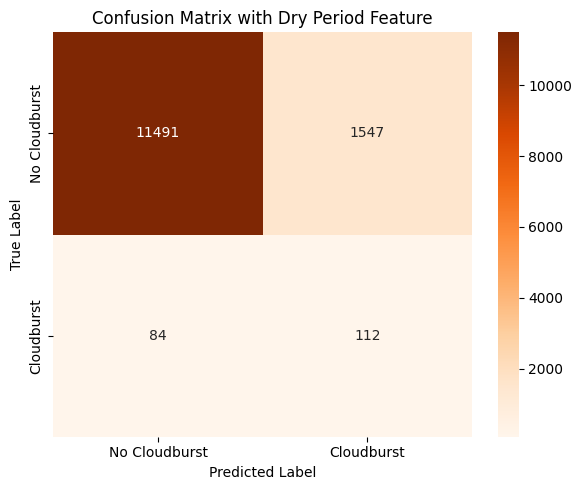

In [45]:
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_enhanced, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['No Cloudburst', 'Cloudburst'],
            yticklabels=['No Cloudburst', 'Cloudburst'])

plt.title('Confusion Matrix with Dry Period Feature')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

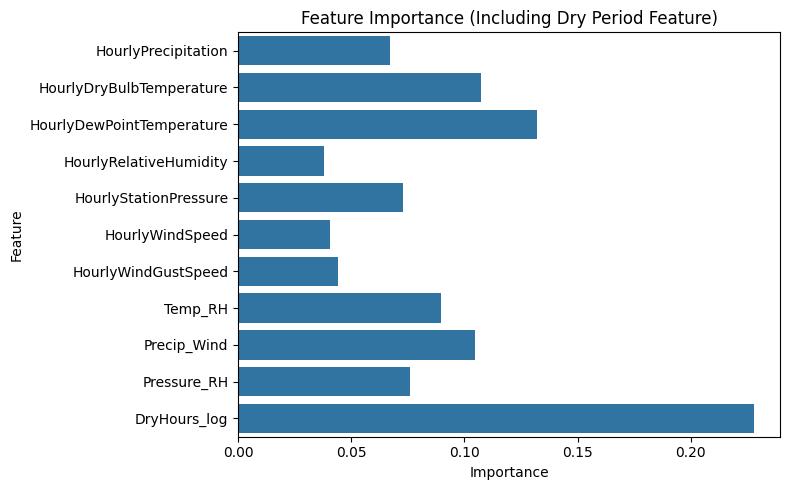

In [46]:
importances = rf_enhanced.feature_importances_
feature_names = features_enhanced

# Plot feature importances
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Feature Importance (Including Dry Period Feature)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

After incorporating the DryHours_log feature, the model’s precision slightly improved from 0.0617 to 0.0675, while recall decreased slightly from 0.5867 to 0.5714. This suggests that the dry period feature helped the model make slightly more confident predictions (fewer false positives), though it became slightly more conservative in identifying cloudbursts overall.

Notably, feature importance rankings show that DryHours_log became the most influential feature, suggesting it captured a meaningful signal related to cloudburst risk. This supports the idea that prolonged dry periods can prime the atmosphere for sudden rainfall, as discussed in the cloudburst article.

### Reflection question: What have you learned about time series data modeling and feature engineering through this assignment? 

Through this assignment, I learned that modeling time series data—especially weather—requires preserving temporal structure to avoid data leakage and misleading performance. Unlike random splits, using chronological splits helped me better simulate real forecasting conditions. I also discovered that feature engineering plays a crucial role in improving model performance. Adding interaction terms and custom features like log-transformed dry periods helped capture more complex atmospheric patterns. Overall, this experience deepened my understanding of how to thoughtfully prepare and enrich time-dependent data for machine learning.